<a href="https://colab.research.google.com/github/mehedi-4/diabetes-prediction/blob/main/free_code_camp_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv('/content/drive/MyDrive/tf data/wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=['description', 'points'])

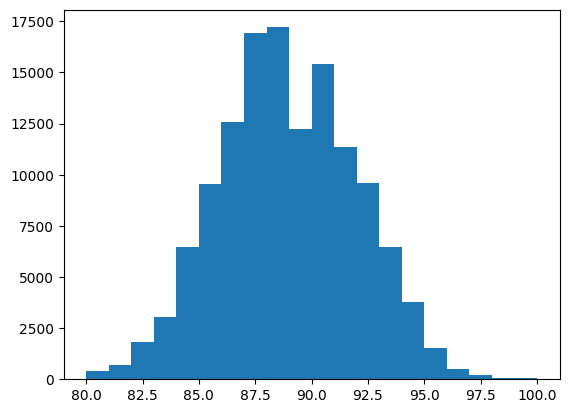

In [5]:
plt.hist(df.points, bins=20)
plt.show()

In [6]:
df['label'] = (df['points'] > 90).astype(int)
df = df[['description', 'label']]
df.sample(5)

,description,label
13569,"This stylish lightweight has some tasty pear, ...",0
106217,Prune and raisin aromas are dominant and sugge...,0
129223,"A bit raw and hot on the nose, with wild berry...",0
38983,"With a wine like this, you can see the connect...",1
94934,The wine has blackberry fruits that give attra...,0


In [7]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [9]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [66]:
inputs = tf.keras.Input(shape=(), dtype=tf.string)

hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim50/2",
    trainable=True
)
# Wrap in Lambda and specify output_shape
x = tf.keras.layers.Lambda(lambda t: hub_layer(t), output_shape=(50,))(inputs)

# Dense layers
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

# Output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [58]:
history = model.fit(train_data, epochs=15, validation_data=valid_data)

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7553 - loss: 0.5120 - val_accuracy: 0.7597 - val_loss: 0.4985
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7505 - loss: 0.5148 - val_accuracy: 0.7577 - val_loss: 0.4984
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7548 - loss: 0.5125 - val_accuracy: 0.7572 - val_loss: 0.4976
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7566 - loss: 0.5086 - val_accuracy: 0.7615 - val_loss: 0.4955
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7561 - loss: 0.5096 - val_accuracy: 0.7612 - val_loss: 0.4950
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7559 - loss: 0.5073 - val_accuracy: 0.7629 - val_loss: 0.4936
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7548 - loss: 0.5080 - val_accuracy: 0.7619 - val_loss: 0.4944
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7572 - loss: 0.5071 - val_accu

In [59]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7630 - loss: 0.4927


[0.49146124720573425, 0.7647330164909363]

# LSTM

In [60]:

encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [61]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [62]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [63]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [64]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 424ms/step - accuracy: 0.7249 - loss: 0.5894 - val_accuracy: 0.8380 - val_loss: 0.3543
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 440ms/step - accuracy: 0.8435 - loss: 0.3505 - val_accuracy: 0.8458 - val_loss: 0.3289
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.8603 - loss: 0.3171 - val_accuracy: 0.8573 - val_loss: 0.3172
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 440ms/step - accuracy: 0.8677 - loss: 0.3021 - val_accuracy: 0.8556 - val_loss: 0.3177
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.8688 - loss: 0.2979 - val_accuracy: 0.8574 - val_loss: 0.3198


In [65]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.8621 - loss: 0.2977


[0.3064849078655243, 0.8589013814926147]

# NeuralNetIII

In [72]:
model = tf.keras.Sequential([
    encoder,  # Text → integers
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [73]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [74]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


102/102 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7256 - loss: 1.1276 - val_accuracy: 0.7508 - val_loss: 0.6534
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.8596 - loss: 0.4132 - val_accuracy: 0.7431 - val_loss: 0.5708
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8666 - loss: 0.3127 - val_accuracy: 0.7412 - val_loss: 0.5700
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8745 - loss: 0.2899 - val_accuracy: 0.7439 - val_loss: 0.4841
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8851 - loss: 0.2727 - val_accuracy: 0.7734 - val_loss: 0.4285


In [75]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 580ms/step - accuracy: 0.7685 - loss: 0.4344


[0.4291640818119049, 0.7702723741531372]

# NeuralNetIV

In [76]:
model = tf.keras.Sequential([
    encoder,                               # Text → integers
    tf.keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()),
    output_dim=32,
    mask_zero=True
    ),            # Word embeddings
    tf.keras.layers.GlobalAveragePooling1D(),                  # Reduce sequence
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")             # Binary output
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(train_data, epochs=5, validation_data=valid_data)


Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7280 - loss: 0.6067 - val_accuracy: 0.7461 - val_loss: 0.4933
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7729 - loss: 0.4586 - val_accuracy: 0.8203 - val_loss: 0.3800
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8290 - loss: 0.3714 - val_accuracy: 0.8280 - val_loss: 0.3637
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8393 - loss: 0.3542 - val_accuracy: 0.8331 - val_loss: 0.3585
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8441 - loss: 0.3460 - val_accuracy: 0.8330 - val_loss: 0.3568


In [77]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8395 - loss: 0.3517


[0.3473145365715027, 0.8389752507209778]